In [ ]:
!pip -q install roboflow
!pip -q install ultralytics==8.*  # YOLOv8
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# ========= CODE ===========
import os, glob, math, cv2, numpy as np, matplotlib.pyplot as plt
import math
from ultralytics import YOLO
import json, pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="fZIAXRUsqh0fwqIgP2IT")
# project = rf.workspace("kltn-3qu1y").project("drill_detection-mf0zz")
# version = project.version(14)
# dataset = version.download("coco-segmentation")
from roboflow import Roboflow
rf = Roboflow(api_key="fZIAXRUsqh0fwqIgP2IT")
project = rf.workspace("kltn-3qu1y").project("drill_detection-mf0zz")
version = project.version(18)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drill_Detection-18 in coco-segmentation:: 100%|██████████| 1044/1044 [00:04<00:00, 211.73it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
categories = [
        {
            "id": 0,
            "name": "drill",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Gay",
            "supercategory": "drill"
        },
        {
            "id": 2,
            "name": "Me",
            "supercategory": "drill"
        },
        {
            "id": 3,
            "name": "Mon_dau",
            "supercategory": "drill"
        },
        {
            "id": 4,
            "name": "Ri_set",
            "supercategory": "drill"
        },
        {
            "id": 5,
            "name": "Xuoc",
            "supercategory": "drill"
        }
    ]

In [ ]:
import os
import json
from PIL import Image

# Thư mục chứa ảnh
image_dir = "/content/drive/MyDrive/KLTN/ver9_update82_full"

# Lấy danh sách ảnh
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.bmp'))]

print(len(image_paths))

82


In [ ]:
images = []
for idx, path in enumerate(image_paths, start=1):
    with Image.open(path) as img:
        width, height = img.size
    images.append({
        "id": idx,
        "file_name": os.path.basename(path),
        "width": width,
        "height": height
    })

coco_format = {
    "info": {},
    "licenses": [],
    "images": images,
    "annotations": [],
    "categories": categories
}

with open("annotations.json", "w", encoding="utf-8") as f:
    json.dump(coco_format, f, indent=4, ensure_ascii=False)

#test

In [ ]:
def load_coco_image_df(coco, image_file):
    """
    Đọc COCO (đúng format file bạn gửi) và trả về DataFrame chứa toàn bộ annotation
    của MỘT ảnh:
      - Thông tin ảnh: image_id, image_file, image_w, image_h
      - Nhãn: category_id, category_name, ann_id, iscrowd, area
      - BBox: bbox_x,y,w,h (+ x2,y2, cx,cy, bbox_area)
      - Segmentation: seg_type='poly', seg_num_points, segmentation (list[list[float]])
    Lưu ý: file này không có RLE (iscrowd=0); nếu có, bạn có thể mở rộng sau.
    """

    images = coco.get("images", [])
    anns   = coco.get("annotations", [])
    cats   = coco.get("categories", [])

    id2name = {c["id"]: c["name"] for c in cats}

    im = next((im for im in images if im.get("file_name") == os.path.basename(image_file)), None)

    img_id = int(im["id"])
    W, H   = int(im["width"]), int(im["height"])
    img_name = im["file_name"]

    rows = []
    for ann in anns:
        if int(ann.get("image_id")) != img_id:
            continue

        # BBox: COCO xywh
        x, y, w, h = ann["bbox"]
        x2, y2 = x + w, y + h
        cx, cy = x + w/2.0, y + h/2.0

        # Segmentation (file của bạn là polygon)
        seg = ann.get("segmentation", [])
        seg_type = "poly" if isinstance(seg, list) else "none"
        seg_num_points = int(sum(len(r)//2 for r in seg)) if seg_type == "poly" else 0

        rows.append({
            "image_file": img_name,
            "image_id": img_id,
            "image_w": W, "image_h": H,

            "ann_id": ann.get("id"),
            "category_id": ann["category_id"],
            "category_name": id2name.get(ann["category_id"], str(ann["category_id"])),
            "iscrowd": int(ann.get("iscrowd", 0)),
            "area": float(ann.get("area", w*h)),

            "bbox_x": float(x), "bbox_y": float(y),
            "bbox_w": float(w), "bbox_h": float(h),
            "bbox_x2": float(x2), "bbox_y2": float(y2),
            "bbox_cx": float(cx), "bbox_cy": float(cy),
            "bbox_area": float(w*h),

            "seg_type": seg_type,
            "seg_num_points": seg_num_points,
            "segmentation": seg,
        })

    df = pd.DataFrame(rows)
    return df,cats

In [ ]:
coco_path = "/content/Drill_Detection-18/valid/_annotations.coco.json"
with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)
img_path = "/content/Drill_Detection-18/valid/S133_Image__2025-09-23__15-40-23_bright_3_bmp.rf.83f70035b6e7d7a845933ec50845a2bb.jpg"

df,categories  = load_coco_image_df(coco, image_file=img_path)

df.head()

,image_file,image_id,image_w,image_h,ann_id,category_id,category_name,iscrowd,area,bbox_x,...,bbox_w,bbox_h,bbox_x2,bbox_y2,bbox_cx,bbox_cy,bbox_area,seg_type,seg_num_points,segmentation
0,S133_Image__2025-09-23__15-40-23_bright_3_bmp....,93,4024,3036,543,5,Xuoc,0,10200.852,3081.0,...,138.036,73.900,3219.036,1172.900,3150.0180,1135.9500,10200.860400,poly,4,"[[3081.183, 1150.836, 3210.14, 1099.408, 3219...."
1,S133_Image__2025-09-23__15-40-23_bright_3_bmp....,93,4024,3036,544,5,Xuoc,0,14319.351,3043.0,...,152.658,93.800,3195.658,2053.800,3119.3290,2006.9000,14319.320400,poly,4,"[[3057.785, 1960.207, 3195.727, 2014.994, 3179..."
2,S133_Image__2025-09-23__15-40-23_bright_3_bmp....,93,4024,3036,545,5,Xuoc,0,11246.328,2465.0,...,83.955,133.957,2548.955,2685.957,2506.9775,2618.9785,11246.359935,poly,4,"[[2465.398, 2566.02, 2514.166, 2685.779, 2549...."
3,S133_Image__2025-09-23__15-40-23_bright_3_bmp....,93,4024,3036,546,5,Xuoc,0,8543.964,1599.0,...,70.229,121.659,1669.229,2716.659,1634.1145,2655.8295,8543.989911,poly,4,"[[1645.155, 2595.014, 1598.74, 2706.45, 1620.4..."


In [ ]:
categories

[{'id': 0, 'name': 'drill', 'supercategory': 'none'},
 {'id': 1, 'name': 'Gay', 'supercategory': 'drill'},
 {'id': 2, 'name': 'Me', 'supercategory': 'drill'},
 {'id': 3, 'name': 'Mon_dau', 'supercategory': 'drill'},
 {'id': 4, 'name': 'Ri_set', 'supercategory': 'drill'},
 {'id': 5, 'name': 'Xuoc', 'supercategory': 'drill'}]

In [ ]:
# ==== CONFIG ====
MODEL_PATH = "/content/last.pt"
model = YOLO(MODEL_PATH)

In [ ]:
def order_tl_tr_br_bl(pts4):
    pts4 = np.asarray(pts4, np.float32)
    s = pts4.sum(1);
    d = np.diff(pts4, axis=1).ravel()
    tl = pts4[np.argmin(s)];
    br = pts4[np.argmax(s)]
    tr = pts4[np.argmin(d)];
    bl = pts4[np.argmax(d)]
    return np.stack([tl,tr,br,bl], 0)

def rotate_quad_to_head_top(box4, center_xy):
    # đưa CẠNH gần tâm lên phía TRÊN
    p0,p1,p2,p3 = box4.astype(np.float32)              # TL,TR,BR,BL
    mids = [(p0+p1)/2, (p1+p2)/2, (p2+p3)/2, (p3+p0)/2]# top,right,bottom,left
    cx, cy = center_xy
    d = [np.hypot(m[0]-cx, m[1]-cy) for m in mids]
    k = int(np.argmin(d))                              # cạnh gần tâm
    return np.roll(box4, -k, axis=0)                   # đưa thành cạnh trên


def angle_score(center_rect, cxy):
    x,y = center_rect
    th = (np.degrees(np.arctan2(y-cxy[1], x-cxy[0])) + 360.0) % 360.0
    return (th - 270.0) % 360.0  # 0° tại 12h, CW

In [ ]:
def results_to_coco_dfs(
    results,
    image_prefix="img",           # prefix tên file cho crop của ảnh này
    save_dir=None,                # nếu muốn lưu crop ra đĩa; None = không lưu
    start_img_id=1,
    start_ann_id=1,
    default_category_id=0,        # dùng khi thiếu nhãn cho bbox
):
    """
    Input (cho MỘT ảnh):
      results: list[dict] mỗi dict tối thiểu có:
        - "crop_bgra": ảnh crop (H,W,4)
        - "bboxes_in_crop": list[[x,y,w,h], ...]
        - (khuyến nghị) "category_ids_in_crop": list[int] (cùng chiều bboxes)
    Output:
      images_df (id, file_name, width, height),
      annotations_df (id, image_id, category_id, bbox(list[4]), area, iscrowd),
      categories_df (id, name, supercategory),
      next_img_id, next_ann_id
    """
    assert isinstance(results, list), "results phải là list"

    images_rows, ann_rows = [], []
    img_id, ann_id = int(start_img_id), int(start_ann_id)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    index_crop = 1
    for k, item in enumerate(results):
        crop_bgra = item["crop_bgra"]
        Hc, Wc = int(crop_bgra.shape[0]), int(crop_bgra.shape[1])
        file_name = f"{image_prefix}_crop_{index_crop}.jpg"
        index_crop = index_crop + 1
        # lưu crop (tuỳ chọn)
        if save_dir is not None:
            path = os.path.join(save_dir, file_name)
            cv2.imwrite(path, cv2.cvtColor(crop_bgra, cv2.COLOR_BGRA2BGR))

        # images row
        images_rows.append({
            "id": img_id,
            "file_name": file_name,
            "width": Wc,
            "height": Hc
        })

        # annotations rows
        bboxes = item.get("bboxes_in_crop", []) or []
        cat_ids = item.get("category_ids_in_crop")  # list[int] cùng chiều bboxes

        for j, b in enumerate(bboxes):
            x, y, w, h = [float(v) for v in b]
            # an toàn: clip vào size crop
            if w <= 0 or h <= 0:
                continue

            if cat_ids is not None and j < len(cat_ids):
                cid = int(cat_ids[j])
            else:
                cid = int(default_category_id)

            ann_rows.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cid,
                "bbox": [x, y, w, h],     # COCO: xywh
                "area": float(w*h),
                "iscrowd": 0,
            })
            ann_id += 1

        img_id += 1

    images_df = pd.DataFrame(images_rows, columns=["id","file_name","width","height"])
    annotations_df = pd.DataFrame(ann_rows, columns=["id","image_id","category_id","bbox","area","iscrowd"])
    return images_df, annotations_df, img_id, ann_id

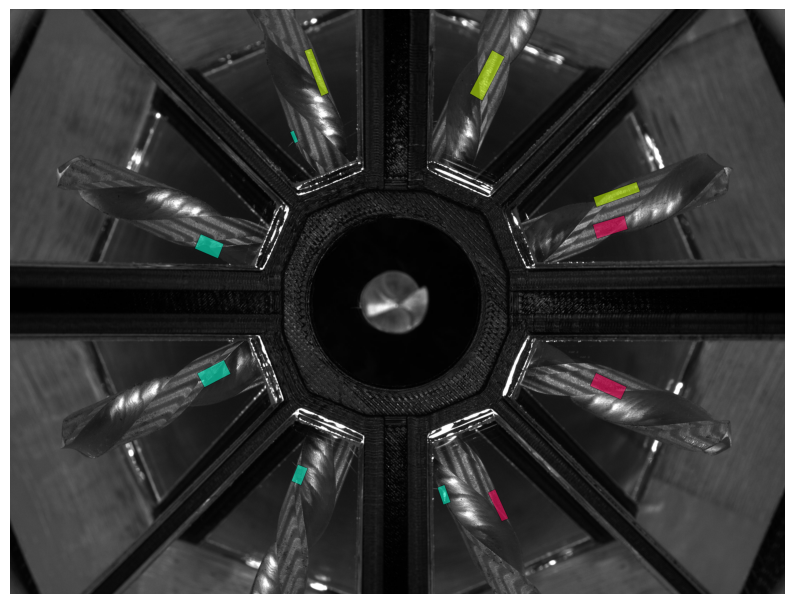

In [ ]:
# ==== VẼ SEGMENT TỪ DATAFRAME df (1 ảnh) ====
# Yêu cầu df có các cột (ít nhất):
#  - image_w, image_h  (hoặc cung cấp ảnh gốc để suy ra kích thước)
#  - category_id, (tùy chọn) category_name
#  - segmentation: list các ring polygon [[x1,y1,...], [..], ...]  (hoặc cột seg_polys_np)
#  - bbox_x, bbox_y, bbox_w, bbox_h (nếu muốn vẽ bbox)
# Nếu df của bạn chứa nhiều ảnh, hãy lọc trước: df_img = df[df["image_file"]==img_name]

# ==== cấu hình nhanh ====
DRAW_BBOX = True          # vẽ thêm bbox để kiểm tra
ALPHA_FILL = 0.55         # độ trong suốt khi tô segment
IMG_PATH   = img_path         # path ảnh gốc; nếu None sẽ vẽ nền trắng theo image_w/h
# ===== Bảng màu (BGR cho OpenCV) =====
CLASS_COLOR = {
    "1": (134, 34, 255),
    "2": (0, 255, 206),
    "3": (255, 128, 0),
    "4": (254, 0, 86),
    "5": (199, 252, 0),
}
# ===== helpers =====
def color_of(name):  # fallback nếu class lạ
    return CLASS_COLOR.get(str(name), (0, 255, 255))  # default: yellow

def row_polygons(row):
    """Trả về list[np.ndarray(N,2)] từ row (ưu tiên seg_polys_np, fallback segmentation)."""
    if "seg_polys_np" in row and isinstance(row["seg_polys_np"], list):
        # đã là list các np.ndarray hoặc list
        polys = []
        for p in row["seg_polys_np"]:
            a = np.array(p, dtype=np.float32)
            a = a.reshape(-1, 2) if a.ndim != 2 else a.astype(np.float32)
            if len(a) >= 3:
                polys.append(a)
        return polys
    seg = row.get("segmentation", None)
    if isinstance(seg, list) and len(seg) > 0 and isinstance(seg[0], (list, tuple)):
        polys = []
        for ring in seg:
            a = np.array(ring, dtype=np.float32).reshape(-1, 2)
            if len(a) >= 3:
                polys.append(a)
        return polys
    return []

def draw_segments_from_df(df_img, img_path=None, alpha=0.55, draw_bbox=True):
    # chuẩn bị canvas
    if img_path and os.path.exists(img_path):
        base = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if base is None:
            raise RuntimeError(f"Không đọc được ảnh: {img_path}")
        # nếu df có image_w/h và không khớp kích thước ảnh → resize cho trùng
        if "image_w" in df_img.columns and "image_h" in df_img.columns:
            W, H = int(df_img["image_w"].iloc[0]), int(df_img["image_h"].iloc[0])
            if (base.shape[1], base.shape[0]) != (W, H):
                base = cv2.resize(base, (W, H), interpolation=cv2.INTER_LINEAR)
    else:
        # nền trắng cần có image_w/h trong df
        assert "image_w" in df_img.columns and "image_h" in df_img.columns, \
            "Thiếu image_w/image_h; hãy cung cấp IMG_PATH hoặc thêm 2 cột này vào df."
        W, H = int(df_img["image_w"].iloc[0]), int(df_img["image_h"].iloc[0])
        base = np.ones((H, W, 3), np.uint8)*255

    overlay = base.copy()

    # vẽ từng instance
    for _, row in df_img.iterrows():
        cid = int(row.get("category_id", 0))
        color = color_of(cid)

        # 1) Vẽ vùng segment (polygon)
        polys = row_polygons(row)
        for poly in polys:
            pts_i = np.round(poly).astype(np.int32).reshape(-1, 1, 2)
            cv2.fillPoly(overlay, [pts_i], color)                  # tô
            cv2.polylines(overlay, [pts_i], True, (0,0,0), 2)      # viền


    # trộn overlay lên base
    draw = cv2.addWeighted(overlay, alpha, base, 1-alpha, 0)
    return draw

# ===== chạy vẽ =====
# Nếu df chứa nhiều ảnh, lọc trước:
# df_img = df[df["image_file"] == os.path.basename(IMG_PATH)].reset_index(drop=True)
df_img = df.copy()  # giả sử df hiện đã là 1 ảnh

canvas = draw_segments_from_df(df_img, img_path=IMG_PATH, alpha=ALPHA_FILL, draw_bbox=DRAW_BBOX)


plt.figure(figsize=(10,10))
#plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.imshow(canvas)
plt.axis('off');
plt.show()

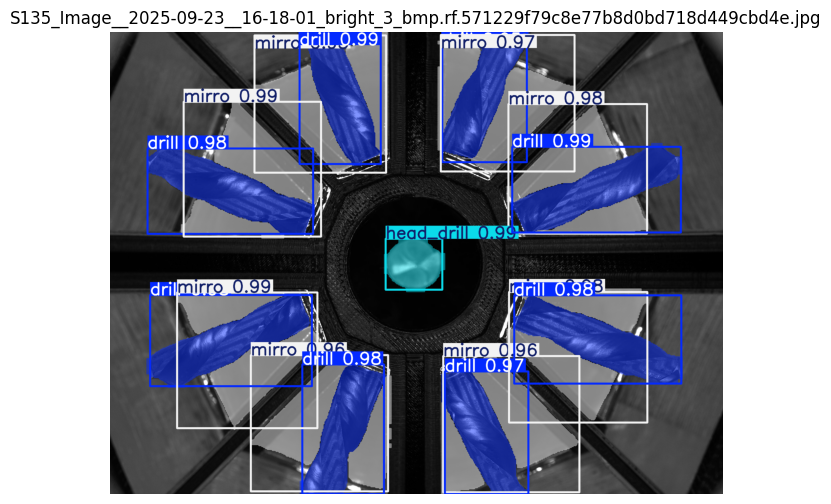

In [ ]:
# ==== CONFIG ====
img_path = "/content/Drill_Detection-18/valid/S135_Image__2025-09-23__16-18-01_bright_3_bmp.rf.571229f79c8e77b8d0bd718d449cbd4e.jpg"
df,categories  = load_coco_image_df(coco, image_file=img_path)
IMG_PATH   = img_path
res = model.predict(
    source=IMG_PATH,
    imgsz=640,
    conf=0.50,
    iou=0.2,
    exist_ok=True,
    verbose=False
)

annotated = res[0].plot()             # BGR với mask/box/label
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.title(os.path.basename(IMG_PATH))
plt.axis("off")
plt.show()
r = res[0]
cls_ids = r.boxes.cls.int().cpu().tolist()
img_bgr = cv2.imread(IMG_PATH)

0
3
4
5
6
8
10
12
16


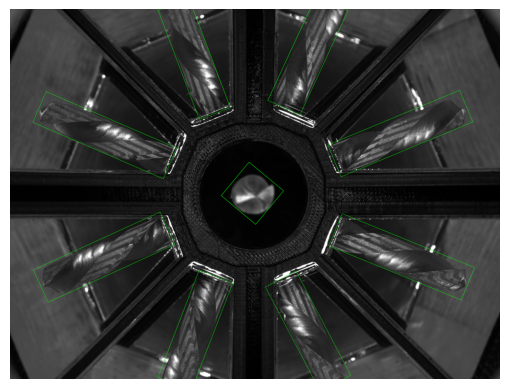

In [ ]:
vis  = img_bgr.copy()

for i in range(len(cls_ids)):
    if cls_ids[i] != 2:
      print(i)
      poly = r.masks.xy[i]
      cnt = np.int32(poly).reshape(-1, 1, 2)
      rect = cv2.minAreaRect(cnt)
      box = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))

      # Kiểm tra kiểu dữ liệu của box và đảm bảo đúng cấu trúc
      box = np.array(box, dtype=np.int32).reshape(-1, 1, 2)

      # Vẽ cạnh hình chữ nhật
      cv2.polylines(vis, [box], True, (0, 255, 0), 2)

# Hiển thị (nếu muốn)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

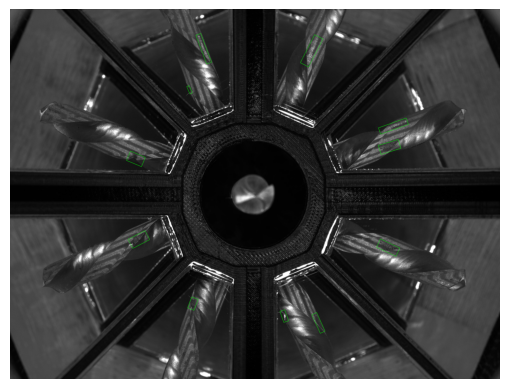

In [ ]:
img_path = "/content/Drill_Detection-18/valid/S135_Image__2025-09-23__16-18-01_bright_3_bmp.rf.571229f79c8e77b8d0bd718d449cbd4e.jpg"
vis = cv2.imread(img_path, cv2.IMREAD_COLOR)
df,categories  = load_coco_image_df(coco, image_file=img_path)
quads_all, quad_cat_ids = [], []
for _, row in df.iterrows():
    cnt = np.int32(row["segmentation"]).reshape(-1, 1, 2)
    rect = cv2.minAreaRect(cnt)
    box = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))
    quads_all.append(box)
    quad_cat_ids.append(int(row["category_id"]))
    # Kiểm tra kiểu dữ liệu của box và đảm bảo đúng cấu trúc
    box = np.array(box, dtype=np.int32).reshape(-1, 1, 2)
    # Vẽ cạnh hình chữ nhật
    cv2.polylines(vis, [box], True, (0, 255, 0), 2)

# Hiển thị (nếu muốn)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
def warp_points(pts, M):
    """pts: (N,2). Trả (N,2) float32 sau khi warp bằng homography M."""
    p  = np.asarray(pts, np.float32).reshape(-1, 2)
    ph = np.hstack([p, np.ones((len(p), 1), np.float32)])  # N×3
    qh = (M @ ph.T).T
    return qh[:, :2] / (qh[:, 2:3] + 1e-8)

def bboxes_from_quads_in_crop(
    quads, M_rot, out_wh, mask_limit=None,
    method="mask", clip=True, skip_empty=True
):
    """
    quads      : list các quad 4 điểm (4,2) trong ảnh gốc (cùng hệ với img_bgr).
    M_rot      : homography từ ảnh gốc -> ảnh crop (đã gồm rotate nếu có).
    out_wh     : (out_w, out_h) của ảnh crop.
    mask_limit : (tùy chọn) mask ROI sau warp (vd. mkeep_warp) để chỉ lấy phần giao.
    method     : "mask" (ổn định với vượt biên) | "geom" (nhanh hơn, hình học thuần).
    clip       : có clip toạ độ về [0..W-1],[0..H-1] trước khi tính bbox (với "geom").
    skip_empty : True -> bỏ qua quad không còn điểm hợp lệ trong ROI.
    Trả về:
      bboxes   : list [[x,y,w,h], ...] theo thứ tự đầu vào.
    """
    out_w, out_h = map(int, out_wh)
    bboxes = []

    for q in quads:
        q = np.asarray(q, np.float32).reshape(4, 2)
        q_crop = warp_points(q, M_rot)  # (4,2) trong ảnh crop

        if method == "mask":
            # raster rồi boundingRect phần giao (ổn khi polygon vượt biên / bị cắt)
            tmp = np.zeros((out_h, out_w), np.uint8)
            cv2.fillPoly(tmp, [np.int32(np.round(q_crop))], 255)
            if mask_limit is not None:
                tmp = cv2.bitwise_and(tmp, mask_limit)
            if skip_empty and tmp.sum() == 0:
                continue
            x, y, w, h = cv2.boundingRect(tmp)
            bboxes.append([float(x), float(y), float(w), float(h)])
        else:  # "geom"
            p = q_crop.copy()
            if clip:
                p[:, 0] = np.clip(p[:, 0], 0, out_w - 1)
                p[:, 1] = np.clip(p[:, 1], 0, out_h - 1)
            x1, y1 = p.min(axis=0)
            x2, y2 = p.max(axis=0)
            w = max(0.0, float(x2 - x1))
            h = max(0.0, float(y2 - y1))
            if skip_empty and (w == 0.0 or h == 0.0):
                continue
            bboxes.append([float(x1), float(y1), w, h])

    return bboxes

In [ ]:
def crop_from_box4_fixed_h(img, box4, center_xy,
                           out_h_src=700, out_w_norm=None,
                           pad_lr=15,                  # padding trái/phải (mỗi bên)
                           pad_tb=0,                   # ✅ padding trên/dưới (mỗi bên)
                           head_down=False, rotate180=False,
                           clamp_height=False):

    box4 = np.asarray(box4, np.float32)
    box_ord = order_tl_tr_br_bl(box4)
    box_top = rotate_quad_to_head_top(box_ord, center_xy)
    if head_down:
        box_top = np.roll(box_top, -2, axis=0)

    TL, TR, BR, BL = box_top.astype(np.float32)
    vL, vR = BL - TL, BR - TR
    hL, hR = float(np.linalg.norm(vL)), float(np.linalg.norm(vR))
    uL, uR = vL / (hL + 1e-6), vR / (hR + 1e-6)

    # chiều cao dải (luôn 700 nếu clamp_height=False)
    h_eff = float(min(out_h_src, hL, hR)) if clamp_height else float(out_h_src)

    TL2, TR2 = TL, TR
    BL2 = TL + uL * h_eff
    BR2 = TR + uR * h_eff
    src_quad = np.stack([TL2, TR2, BR2, BL2], 0).astype(np.float32)

    # kích thước lõi + padding
    out_h_core = int(round(h_eff))
    w_core = max(4.0, float(np.linalg.norm(TR2 - TL2))) if out_w_norm is None else float(out_w_norm)
    w_core = int(round(w_core))

    pad_x = int(max(0, pad_lr))   # mỗi bên trái/phải
    pad_y = int(max(0, pad_tb))   # mỗi bên trên/dưới

    out_w = w_core + 2 * pad_x
    out_h = out_h_core + 2 * pad_y

    # dịch dst_quad theo padding: (pad_x, pad_y)
    dst_quad = np.array([[pad_x,               pad_y],
                         [pad_x + w_core - 1,  pad_y],
                         [pad_x + w_core - 1,  pad_y + out_h_core - 1],
                         [pad_x,               pad_y + out_h_core - 1]], np.float32)

    # chuẩn hoá kênh ảnh
    if img.ndim == 3 and img.shape[2] == 4:
        img_for_warp = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    else:
        img_for_warp = img

    # homography + warp
    M = cv2.getPerspectiveTransform(src_quad, dst_quad)
    if rotate180:
        R180 = np.array([[-1, 0, out_w - 1],
                         [ 0,-1, out_h - 1],
                         [ 0, 0,         1]], dtype=np.float32)
        M = R180 @ M
        dst_quad = warp_points(dst_quad, R180)

    crop = cv2.warpPerspective(img_for_warp, M, (out_w, out_h),
                               flags=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # BGRA + alpha = vùng dải; padding trong suốt
    if crop.ndim == 2 or (crop.ndim == 3 and crop.shape[2] == 1):
        out_bgr = cv2.cvtColor(crop, cv2.COLOR_GRAY2BGR)
    elif crop.ndim == 3 and crop.shape[2] == 3:
        out_bgr = crop
    else:
        out_bgr = cv2.cvtColor(crop, cv2.COLOR_BGRA2BGR)

    out_bgra = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2BGRA)
    alpha = np.zeros((out_h, out_w), np.uint8)
    cv2.fillPoly(alpha, [dst_quad.astype(np.int32)], 255)
    out_bgra[..., 3] = alpha

    mkeep = alpha.copy()
    return out_bgra, M, (out_w, out_h), src_quad,dst_quad, mkeep

In [ ]:
def add_black_background(image, new_width = 256, new_height = 700):

    if image.shape[2] == 4:
        # Chuyển ảnh từ BGRA thành BGR (loại bỏ kênh alpha)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    # Lấy chiều cao và chiều rộng của ảnh gốc
    height, width = image.shape[:2]

    # Tạo ảnh nền màu đen với kích thước mới
    black_background = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    # Chèn ảnh gốc vào ảnh nền bắt đầu từ (0, 0)
    black_background[:height, :width] = image

    return cv2.cvtColor(black_background, cv2.COLOR_BGR2BGRA)

def _warp_clip_pts(pts, M, out_wh):
    """Warp pts (N,2) sang crop rồi clip vào [0..W-1],[0..H-1]."""
    W, H = map(int, out_wh)
    p = warp_points(np.asarray(pts, np.float32), M)
    p[:,0] = np.clip(p[:,0], 0, W-1)
    p[:,1] = np.clip(p[:,1], 0, H-1)
    return p

def filter_quads_indices_by_segment_in_crop(poly_seg, quads, M_rot, out_wh,
                                            mode="contains", thr=0.6, dilate_px=0,
                                            return_quads=False):
    """
    Lọc QUADS theo SEGMENT nhưng ở hệ toạ độ sau crop.
    - poly_seg, quads: toạ độ gốc (ảnh ban đầu)
    - M_rot: homography gốc -> crop (đúng cái dùng để warp ảnh)
    - out_wh: (out_w, out_h) của crop hiện tại
    """
    W, H = map(int, out_wh)

    # 1) warp segment sang crop
    seg_pts = _warp_clip_pts(poly_seg, M_rot, (W,H))
    if seg_pts.shape[0] < 3:
        return ([], []) if return_quads else []

    cnt_seg = np.int32(seg_pts.reshape(-1,1,2))

    idxs, quads_kept = [], []

    if mode == "contains":
        for j, q in enumerate(quads):
            q_pts = _warp_clip_pts(q, M_rot, (W,H))
            ok = True
            for (x,y) in q_pts:
                s = cv2.pointPolygonTest(cnt_seg, (float(x), float(y)), False)
                if s < 0:    # (<0: ngoài; đổi <=0 nếu muốn loại cả điểm nằm đúng biên)
                    ok = False; break
            if ok:
                idxs.append(j)
                if return_quads: quads_kept.append(q_pts)
    else:  # overlap theo tỉ lệ area(intersection)/area(quad)
        # mask segment
        m_seg = np.zeros((H,W), np.uint8)
        cv2.fillPoly(m_seg, [cnt_seg], 255)
        if dilate_px > 0:
            k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*dilate_px+1, 2*dilate_px+1))
            m_seg = cv2.dilate(m_seg, k, 1)

        for j, q in enumerate(quads):
            q_pts = _warp_clip_pts(q, M_rot, (W,H))
            if cv2.contourArea(q_pts.astype(np.float32)) <= 0:
                continue
            # ROI để tăng tốc
            x1 = max(0, int(np.floor(q_pts[:,0].min())))
            y1 = max(0, int(np.floor(q_pts[:,1].min())))
            x2 = min(W-1, int(np.ceil (q_pts[:,0].max())))
            y2 = min(H-1, int(np.ceil (q_pts[:,1].max())))
            if x2 <= x1 or y2 <= y1: continue

            m_q = np.zeros((y2-y1+1, x2-x1+1), np.uint8)
            q_roi = q_pts.copy()
            q_roi[:,0] -= x1; q_roi[:,1] -= y1
            cv2.fillPoly(m_q, [np.int32(np.round(q_roi))], 255)

            inter = cv2.bitwise_and(m_q, m_seg[y1:y2+1, x1:x2+1])
            area_q = float(cv2.countNonZero(m_q))
            if area_q <= 0: continue
            ratio = cv2.countNonZero(inter) / area_q

            if ratio >= thr:
                idxs.append(j)
                if return_quads: quads_kept.append(q_pts)

    if return_quads:
        return [int(x) for x in idxs], quads_kept
    return [int(x) for x in idxs]

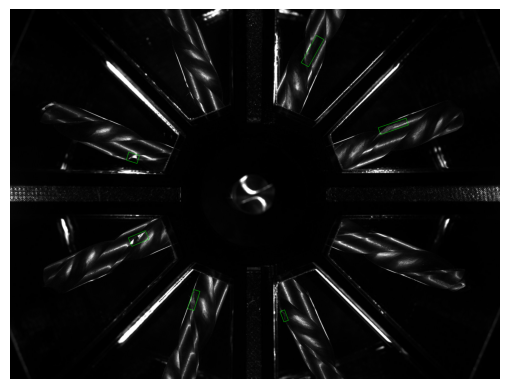

In [ ]:
img_path = "/content/Drill_Detection-18/valid/S135_Image__2025-09-23__16-19-26_dark_3_bmp.rf.d249a74ed12a8fce6aa05f88d0e4cad8.jpg"
vis = cv2.imread(img_path, cv2.IMREAD_COLOR)
df,categories  = load_coco_image_df(coco, image_file=img_path)
quads_all, quad_cat_ids = [], []
for _, row in df.iterrows():
    cnt = np.int32(row["segmentation"]).reshape(-1, 1, 2)
    rect = cv2.minAreaRect(cnt)
    box = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))
    quads_all.append(box)
    quad_cat_ids.append(int(row["category_id"]))
    # Kiểm tra kiểu dữ liệu của box và đảm bảo đúng cấu trúc
    box = np.array(box, dtype=np.int32).reshape(-1, 1, 2)
    # Vẽ cạnh hình chữ nhật
    cv2.polylines(vis, [box], True, (0, 255, 0), 2)

# Hiển thị (nếu muốn)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # grayscale hoặc BGR đều được
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
H, W = img.shape[:2]
OUT_H    = 720       # chiều cao cố định theo ảnh gốc (px)
OUT_W_NORM = 226
pad = 15
# --- center: ưu tiên head_drill (class 1), không có thì tâm ảnh ---
head_idx = next((k for k,c in enumerate(cls_ids) if c==1), None)
if head_idx is not None:
    hpoly = np.asarray(r.masks.xy[head_idx], np.float32)
    cx, cy = float(hpoly[:,0].mean()), float(hpoly[:,1].mean())
else:
    cx, cy = W/2.0, H/2.0
center_xy = (cx, cy)

r = res[0]
results = []

for i, poly in enumerate(r.masks.xy):
    if cls_ids[i] == 0 or cls_ids[i] == 1:
      cnt  = np.int32(poly).reshape(-1,1,2)
      rect = cv2.minAreaRect(cnt)                                # (center,(w,h),angle)
      box4 = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))    # TL,TR,BR,BL


      # 3.3) CẮT + nhận ma trận warp M
      crop_bgra, M_rot, (out_w,out_h), src_quad, dst_quad, mkeep_warp = crop_from_box4_fixed_h(
          img=img_bgr,
          box4=box4,
          center_xy=center_xy,
          out_h_src=OUT_H,
          out_w_norm=OUT_W_NORM,
          pad_lr=pad,
          head_down=False,
          rotate180=True,
          clamp_height=False
      )

      if cls_ids[i] == 1:
          crop_bgra, M_rot, (out_w,out_h), src_quad, dst_quad, mkeep_warp = crop_from_box4_fixed_h(
              img=img_bgr,
              box4=box4,
              center_xy=center_xy,
              out_h_src=OUT_H,
              out_w_norm=OUT_W_NORM,
              pad_lr=pad,
              pad_tb = 50,
              head_down=False,
              rotate180=True,
              clamp_height=True
          )
          # crop_bgra = add_black_background(crop_bgra, new_width=256, new_height=OUT_H)
          # pad lên khung chuẩn 256 x OUT_H (dán tại (0,0))
          new_w = OUT_W_NORM + 2*pad   # 226 + 30 = 256
          new_h = OUT_H                # 720
          if (out_w, out_h) != (new_w, new_h):
              crop_bgra = add_black_background(crop_bgra, new_width=new_w, new_height=new_h)

              # ✅ đồng bộ size để bước tính bbox/clip đúng theo khung mới
              out_w, out_h = new_w, new_h

              # (tùy) nếu còn dùng mask_limit ở nơi khác, pad mask cho khớp size
              if mkeep_warp is not None:
                  Hm, Wm = mkeep_warp.shape[:2]
                  m0 = np.zeros((out_h, out_w), np.uint8)
                  m0[:Hm, :Wm] = mkeep_warp
                  mkeep_warp = m0



      idxs = filter_quads_indices_by_segment_in_crop(
          poly_seg=poly,                # polygon segment ở toạ độ gốc
          quads=quads_all,              # quads ở toạ độ gốc
          M_rot=M_rot,                  # homography gốc -> crop (chính cái dùng để warp ảnh)
          out_wh=(out_w, out_h),        # kích thước crop hiện tại
          mode="overlap",               # hoặc "contains"
          thr=0.5,
          dilate_px=3,
      )

      quads_in_seg = [quads_all[j] for j in idxs]
      cats_in_seg  = [quad_cat_ids[j] for j in idxs]

      bboxes_in_crop = bboxes_from_quads_in_crop(
          quads=quads_in_seg,
          M_rot=M_rot,
          out_wh=(out_w, out_h),
          mask_limit=None,
          method="geom",
          clip=True,
          skip_empty=True
      )

      # 3.6) angle score để sắp xếp 12h→… (CW)
      score = angle_score(rect[0], center_xy)

      #bbox_df = pd.DataFrame(bboxes_in_crop, columns=["x","y","w","h"])
      results.append({
          "seg_idx": i,
          "angle_score": score,
          "crop_bgra": crop_bgra,          # ảnh crop (BGRA)
          "quads_in_seg_global": quads_in_seg,  # quads ở hệ toạ độ gốc
          "bboxes_in_crop": bboxes_in_crop,     # list [x,y,w,h]
          "cls_id": cls_ids[i],
          "category_ids_in_crop": cats_in_seg
      })
results = sorted(results, key=lambda d: (d["cls_id"] == 1, d["angle_score"]))


(720, 256, 3)
(720, 256, 3)
(720, 256, 3)
(720, 256, 3)
(720, 256, 3)
(720, 256, 3)
(720, 256, 3)
(720, 256, 3)
(720, 256, 3)


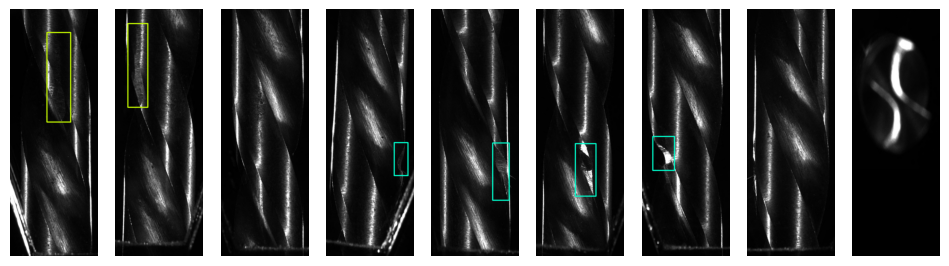

In [ ]:
fig, ax =  plt.subplots(1, 9, figsize=(12, 12))
for i, item in enumerate(results):
  dbg = cv2.cvtColor(item["crop_bgra"], cv2.COLOR_BGRA2BGR).copy()
  k = 0
  for (x,y,w,h) in item["bboxes_in_crop"]:
        x,y,w,h = map(int, [x,y,w,h])
        cv2.rectangle(dbg, (x,y), (x+w,y+h), color_of(item["category_ids_in_crop"][k]), 2, cv2.LINE_AA)
        k = k+1
  #dbg = cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB)
  ax[i].imshow(dbg)
  print(dbg.shape)
  ax[i].axis("off")

  #color_of(item["category_ids_in_crop"])

#Pipeline

In [ ]:
def load_coco_image_df(coco, image_file):
    """
    Đọc COCO (đúng format file bạn gửi) và trả về DataFrame chứa toàn bộ annotation
    của MỘT ảnh:
      - Thông tin ảnh: image_id, image_file, image_w, image_h
      - Nhãn: category_id, category_name, ann_id, iscrowd, area
      - BBox: bbox_x,y,w,h (+ x2,y2, cx,cy, bbox_area)
      - Segmentation: seg_type='poly', seg_num_points, segmentation (list[list[float]])
    Lưu ý: file này không có RLE (iscrowd=0); nếu có, bạn có thể mở rộng sau.
    """

    images = coco.get("images", [])
    anns   = coco.get("annotations", [])
    cats   = coco.get("categories", [])

    id2name = {c["id"]: c["name"] for c in cats}

    im = next((im for im in images if im.get("file_name") == os.path.basename(image_file)), None)

    img_id = int(im["id"])
    W, H   = int(im["width"]), int(im["height"])
    img_name = im["file_name"]

    rows = []
    for ann in anns:
        if int(ann.get("image_id")) != img_id:
            continue

        # BBox: COCO xywh
        x, y, w, h = ann["bbox"]
        x2, y2 = x + w, y + h
        cx, cy = x + w/2.0, y + h/2.0

        # Segmentation (file của bạn là polygon)
        seg = ann.get("segmentation", [])
        seg_type = "poly" if isinstance(seg, list) else "none"
        seg_num_points = int(sum(len(r)//2 for r in seg)) if seg_type == "poly" else 0

        rows.append({
            "image_file": img_name,
            "image_id": img_id,
            "image_w": W, "image_h": H,

            "ann_id": ann.get("id"),
            "category_id": ann["category_id"],
            "category_name": id2name.get(ann["category_id"], str(ann["category_id"])),
            "iscrowd": int(ann.get("iscrowd", 0)),
            "area": float(ann.get("area", w*h)),

            "bbox_x": float(x), "bbox_y": float(y),
            "bbox_w": float(w), "bbox_h": float(h),
            "bbox_x2": float(x2), "bbox_y2": float(y2),
            "bbox_cx": float(cx), "bbox_cy": float(cy),
            "bbox_area": float(w*h),

            "seg_type": seg_type,
            "seg_num_points": seg_num_points,
            "segmentation": seg,
        })

    df = pd.DataFrame(rows)
    return df,cats

In [ ]:
def order_tl_tr_br_bl(pts4):
    pts4 = np.asarray(pts4, np.float32)
    s = pts4.sum(1);
    d = np.diff(pts4, axis=1).ravel()
    tl = pts4[np.argmin(s)];
    br = pts4[np.argmax(s)]
    tr = pts4[np.argmin(d)];
    bl = pts4[np.argmax(d)]
    return np.stack([tl,tr,br,bl], 0)

def rotate_quad_to_head_top(box4, center_xy):
    # đưa CẠNH gần tâm lên phía TRÊN
    p0,p1,p2,p3 = box4.astype(np.float32)              # TL,TR,BR,BL
    mids = [(p0+p1)/2, (p1+p2)/2, (p2+p3)/2, (p3+p0)/2]# top,right,bottom,left
    cx, cy = center_xy
    d = [np.hypot(m[0]-cx, m[1]-cy) for m in mids]
    k = int(np.argmin(d))                              # cạnh gần tâm
    return np.roll(box4, -k, axis=0)                   # đưa thành cạnh trên


def angle_score(center_rect, cxy):
    x,y = center_rect
    th = (np.degrees(np.arctan2(y-cxy[1], x-cxy[0])) + 360.0) % 360.0
    return (th - 270.0) % 360.0  # 0° tại 12h, CW

In [ ]:
def results_to_coco_dfs(
    results,
    image_prefix="img",           # prefix tên file cho crop của ảnh này
    save_dir=None,                # nếu muốn lưu crop ra đĩa; None = không lưu
    start_img_id=1,
    start_ann_id=1,
    default_category_id=0,        # dùng khi thiếu nhãn cho bbox
):
    """
    Input (cho MỘT ảnh):
      results: list[dict] mỗi dict tối thiểu có:
        - "crop_bgra": ảnh crop (H,W,4)
        - "bboxes_in_crop": list[[x,y,w,h], ...]
        - (khuyến nghị) "category_ids_in_crop": list[int] (cùng chiều bboxes)
    Output:
      images_df (id, file_name, width, height),
      annotations_df (id, image_id, category_id, bbox(list[4]), area, iscrowd),
      categories_df (id, name, supercategory),
      next_img_id, next_ann_id
    """
    assert isinstance(results, list), "results phải là list"

    images_rows, ann_rows = [], []
    img_id, ann_id = int(start_img_id), int(start_ann_id)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    index_crop = 1
    for k, item in enumerate(results):
        crop_bgra = item["crop_bgra"]
        Hc, Wc = int(crop_bgra.shape[0]), int(crop_bgra.shape[1])
        file_name = f"{image_prefix}_crop_{index_crop}.jpg"
        index_crop = index_crop + 1
        # lưu crop (tuỳ chọn)
        if save_dir is not None:
            path = os.path.join(save_dir, file_name)
            cv2.imwrite(path, cv2.cvtColor(crop_bgra, cv2.COLOR_BGRA2BGR))

        # images row
        images_rows.append({
            "id": img_id,
            "file_name": file_name,
            "width": Wc,
            "height": Hc
        })

        # annotations rows
        bboxes = item.get("bboxes_in_crop", []) or []
        cat_ids = item.get("category_ids_in_crop")  # list[int] cùng chiều bboxes

        for j, b in enumerate(bboxes):
            x, y, w, h = [float(v) for v in b]
            # an toàn: clip vào size crop
            if w <= 0 or h <= 0:
                continue

            if cat_ids is not None and j < len(cat_ids):
                cid = int(cat_ids[j])
            else:
                cid = int(default_category_id)

            ann_rows.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cid,
                "bbox": [x, y, w, h],     # COCO: xywh
                "area": float(w*h),
                "iscrowd": 0,
            })
            ann_id += 1

        img_id += 1

    images_df = pd.DataFrame(images_rows, columns=["id","file_name","width","height"])
    annotations_df = pd.DataFrame(ann_rows, columns=["id","image_id","category_id","bbox","area","iscrowd"])
    return images_df, annotations_df, img_id, ann_id

In [ ]:
def warp_points(pts, M):
    """pts: (N,2). Trả (N,2) float32 sau khi warp bằng homography M."""
    p  = np.asarray(pts, np.float32).reshape(-1, 2)
    ph = np.hstack([p, np.ones((len(p), 1), np.float32)])  # N×3
    qh = (M @ ph.T).T
    return qh[:, :2] / (qh[:, 2:3] + 1e-8)

def bboxes_from_quads_in_crop(
    quads, M_rot, out_wh, mask_limit=None,
    method="mask", clip=True, skip_empty=True
):
    """
    quads      : list các quad 4 điểm (4,2) trong ảnh gốc (cùng hệ với img_bgr).
    M_rot      : homography từ ảnh gốc -> ảnh crop (đã gồm rotate nếu có).
    out_wh     : (out_w, out_h) của ảnh crop.
    mask_limit : (tùy chọn) mask ROI sau warp (vd. mkeep_warp) để chỉ lấy phần giao.
    method     : "mask" (ổn định với vượt biên) | "geom" (nhanh hơn, hình học thuần).
    clip       : có clip toạ độ về [0..W-1],[0..H-1] trước khi tính bbox (với "geom").
    skip_empty : True -> bỏ qua quad không còn điểm hợp lệ trong ROI.
    Trả về:
      bboxes   : list [[x,y,w,h], ...] theo thứ tự đầu vào.
    """
    out_w, out_h = map(int, out_wh)
    bboxes = []

    for q in quads:
        q = np.asarray(q, np.float32).reshape(4, 2)
        q_crop = warp_points(q, M_rot)  # (4,2) trong ảnh crop

        if method == "mask":
            # raster rồi boundingRect phần giao (ổn khi polygon vượt biên / bị cắt)
            tmp = np.zeros((out_h, out_w), np.uint8)
            cv2.fillPoly(tmp, [np.int32(np.round(q_crop))], 255)
            if mask_limit is not None:
                tmp = cv2.bitwise_and(tmp, mask_limit)
            if skip_empty and tmp.sum() == 0:
                continue
            x, y, w, h = cv2.boundingRect(tmp)
            bboxes.append([float(x), float(y), float(w), float(h)])
        else:  # "geom"
            p = q_crop.copy()
            if clip:
                p[:, 0] = np.clip(p[:, 0], 0, out_w - 1)
                p[:, 1] = np.clip(p[:, 1], 0, out_h - 1)
            x1, y1 = p.min(axis=0)
            x2, y2 = p.max(axis=0)
            w = max(0.0, float(x2 - x1))
            h = max(0.0, float(y2 - y1))
            if skip_empty and (w == 0.0 or h == 0.0):
                continue
            bboxes.append([float(x1), float(y1), w, h])

    return bboxes

In [ ]:
def crop_from_box4_fixed_h(img, box4, center_xy,
                           out_h_src=700, out_w_norm=None,
                           pad_lr=15,                  # padding trái/phải (mỗi bên)
                           pad_tb=0,                   # ✅ padding trên/dưới (mỗi bên)
                           head_down=False, rotate180=False,
                           clamp_height=False):

    box4 = np.asarray(box4, np.float32)
    box_ord = order_tl_tr_br_bl(box4)
    box_top = rotate_quad_to_head_top(box_ord, center_xy)
    if head_down:
        box_top = np.roll(box_top, -2, axis=0)

    TL, TR, BR, BL = box_top.astype(np.float32)
    vL, vR = BL - TL, BR - TR
    hL, hR = float(np.linalg.norm(vL)), float(np.linalg.norm(vR))
    uL, uR = vL / (hL + 1e-6), vR / (hR + 1e-6)

    # chiều cao dải (luôn 700 nếu clamp_height=False)
    h_eff = float(min(out_h_src, hL, hR)) if clamp_height else float(out_h_src)

    TL2, TR2 = TL, TR
    BL2 = TL + uL * h_eff
    BR2 = TR + uR * h_eff
    src_quad = np.stack([TL2, TR2, BR2, BL2], 0).astype(np.float32)

    # kích thước lõi + padding
    out_h_core = int(round(h_eff))
    w_core = max(4.0, float(np.linalg.norm(TR2 - TL2))) if out_w_norm is None else float(out_w_norm)
    w_core = int(round(w_core))

    pad_x = int(max(0, pad_lr))   # mỗi bên trái/phải
    pad_y = int(max(0, pad_tb))   # mỗi bên trên/dưới

    out_w = w_core + 2 * pad_x
    out_h = out_h_core + 2 * pad_y

    # dịch dst_quad theo padding: (pad_x, pad_y)
    dst_quad = np.array([[pad_x,               pad_y],
                         [pad_x + w_core - 1,  pad_y],
                         [pad_x + w_core - 1,  pad_y + out_h_core - 1],
                         [pad_x,               pad_y + out_h_core - 1]], np.float32)

    # chuẩn hoá kênh ảnh
    if img.ndim == 3 and img.shape[2] == 4:
        img_for_warp = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    else:
        img_for_warp = img

    # homography + warp
    M = cv2.getPerspectiveTransform(src_quad, dst_quad)
    if rotate180:
        R180 = np.array([[-1, 0, out_w - 1],
                         [ 0,-1, out_h - 1],
                         [ 0, 0,         1]], dtype=np.float32)
        M = R180 @ M
        dst_quad = warp_points(dst_quad, R180)

    crop = cv2.warpPerspective(img_for_warp, M, (out_w, out_h),
                               flags=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # BGRA + alpha = vùng dải; padding trong suốt
    if crop.ndim == 2 or (crop.ndim == 3 and crop.shape[2] == 1):
        out_bgr = cv2.cvtColor(crop, cv2.COLOR_GRAY2BGR)
    elif crop.ndim == 3 and crop.shape[2] == 3:
        out_bgr = crop
    else:
        out_bgr = cv2.cvtColor(crop, cv2.COLOR_BGRA2BGR)

    out_bgra = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2BGRA)
    alpha = np.zeros((out_h, out_w), np.uint8)
    cv2.fillPoly(alpha, [dst_quad.astype(np.int32)], 255)
    out_bgra[..., 3] = alpha

    mkeep = alpha.copy()
    return out_bgra, M, (out_w, out_h), src_quad,dst_quad, mkeep

In [ ]:
# def add_black_background(image, new_width, new_height):
#     if image.shape[2] == 4:
#         # Convert from BGRA to BGR (remove the alpha channel)
#         image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

#     # Get the original dimensions of the image
#     height, width = image.shape[:2]

#     # Ensure the background is large enough
#     if new_height < height or new_width < width:
#         print("Warning: Background size smaller than image. Resizing image.")
#         # Resize image to fit the background
#         image = cv2.resize(image, (new_width, new_height))
#         height, width = image.shape[:2]  # update new dimensions after resizing

#     # Create a black background with the new dimensions
#     black_background = np.zeros((new_height, new_width, 3), dtype=np.uint8)

#     # Insert the image into the black background (top-left corner)
#     black_background[:height, :width] = image

#     # Convert the final background to BGRA (adding an alpha channel)
#     return cv2.cvtColor(black_background, cv2.COLOR_BGR2BGRA)
def add_black_background(image, new_width=256, new_height=720, center=False):
    # Chuẩn hoá về BGR để ghép nền
    if image.ndim == 3 and image.shape[2] == 4:
        img_bgr = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif image.ndim == 2:
        img_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        img_bgr = image

    h, w = img_bgr.shape[:2]
    # Khung nền đen
    canvas = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    # Nếu crop lớn hơn nền, cắt vừa
    copy_w = min(w, new_width)
    copy_h = min(h, new_height)

    if center:
        x0 = (new_width  - copy_w) // 2
        y0 = (new_height - copy_h) // 2
    else:
        x0, y0 = 0, 0

    canvas[y0:y0+copy_h, x0:x0+copy_w] = img_bgr[:copy_h, :copy_w]
    # Trả BGRA với alpha đầy (255)
    out = cv2.cvtColor(canvas, cv2.COLOR_BGR2BGRA)
    out[..., 3] = 255
    return out

def _warp_clip_pts(pts, M, out_wh):
    """Warp pts (N,2) sang crop rồi clip vào [0..W-1],[0..H-1]."""
    W, H = map(int, out_wh)
    p = warp_points(np.asarray(pts, np.float32), M)
    p[:,0] = np.clip(p[:,0], 0, W-1)
    p[:,1] = np.clip(p[:,1], 0, H-1)
    return p

def filter_quads_indices_by_segment_in_crop(poly_seg, quads, M_rot, out_wh,
                                            mode="contains", thr=0.6, dilate_px=0,
                                            return_quads=False):
    """
    Lọc QUADS theo SEGMENT nhưng ở hệ toạ độ sau crop.
    - poly_seg, quads: toạ độ gốc (ảnh ban đầu)
    - M_rot: homography gốc -> crop (đúng cái dùng để warp ảnh)
    - out_wh: (out_w, out_h) của crop hiện tại
    """
    W, H = map(int, out_wh)

    # 1) warp segment sang crop
    seg_pts = _warp_clip_pts(poly_seg, M_rot, (W,H))
    if seg_pts.shape[0] < 3:
        return ([], []) if return_quads else []

    cnt_seg = np.int32(seg_pts.reshape(-1,1,2))

    idxs, quads_kept = [], []

    if mode == "contains":
        for j, q in enumerate(quads):
            q_pts = _warp_clip_pts(q, M_rot, (W,H))
            ok = True
            for (x,y) in q_pts:
                s = cv2.pointPolygonTest(cnt_seg, (float(x), float(y)), False)
                if s < 0:    # (<0: ngoài; đổi <=0 nếu muốn loại cả điểm nằm đúng biên)
                    ok = False; break
            if ok:
                idxs.append(j)
                if return_quads: quads_kept.append(q_pts)
    else:  # overlap theo tỉ lệ area(intersection)/area(quad)
        # mask segment
        m_seg = np.zeros((H,W), np.uint8)
        cv2.fillPoly(m_seg, [cnt_seg], 255)
        if dilate_px > 0:
            k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*dilate_px+1, 2*dilate_px+1))
            m_seg = cv2.dilate(m_seg, k, 1)

        for j, q in enumerate(quads):
            q_pts = _warp_clip_pts(q, M_rot, (W,H))
            if cv2.contourArea(q_pts.astype(np.float32)) <= 0:
                continue
            # ROI để tăng tốc
            x1 = max(0, int(np.floor(q_pts[:,0].min())))
            y1 = max(0, int(np.floor(q_pts[:,1].min())))
            x2 = min(W-1, int(np.ceil (q_pts[:,0].max())))
            y2 = min(H-1, int(np.ceil (q_pts[:,1].max())))
            if x2 <= x1 or y2 <= y1: continue

            m_q = np.zeros((y2-y1+1, x2-x1+1), np.uint8)
            q_roi = q_pts.copy()
            q_roi[:,0] -= x1; q_roi[:,1] -= y1
            cv2.fillPoly(m_q, [np.int32(np.round(q_roi))], 255)

            inter = cv2.bitwise_and(m_q, m_seg[y1:y2+1, x1:x2+1])
            area_q = float(cv2.countNonZero(m_q))
            if area_q <= 0: continue
            ratio = cv2.countNonZero(inter) / area_q

            if ratio >= thr:
                idxs.append(j)
                if return_quads: quads_kept.append(q_pts)

    if return_quads:
        return [int(x) for x in idxs], quads_kept
    return [int(x) for x in idxs]

In [ ]:
# ==== CONFIG ====
MODEL_PATH = "/content/last.pt"
model = YOLO(MODEL_PATH)

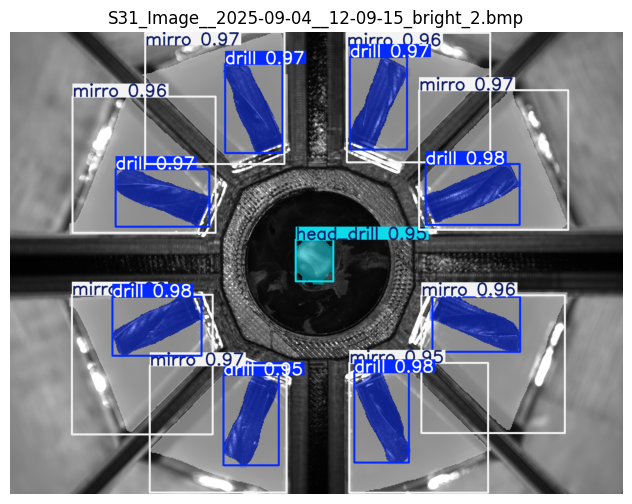

[0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0]


In [ ]:
# ==== CONFIG ====
IMG_PATH_DEFAULT   = "/content/S31_Image__2025-09-04__12-09-15_bright_2.bmp"
res = model.predict(
    source=IMG_PATH_DEFAULT,
    imgsz=640,
    conf=0.40,
    iou=0.4,
    exist_ok=True,
    verbose=False
)
r_default = res[0]
annotated = res[0].plot()             # BGR với mask/box/label
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.title(os.path.basename(IMG_PATH_DEFAULT))
plt.axis("off")
plt.show()
cls_ids = r_default.boxes.cls.int().cpu().tolist()
print(cls_ids)
img_bgr = cv2.imread(IMG_PATH_DEFAULT)

0
1
2
5
7
8
13
15
16


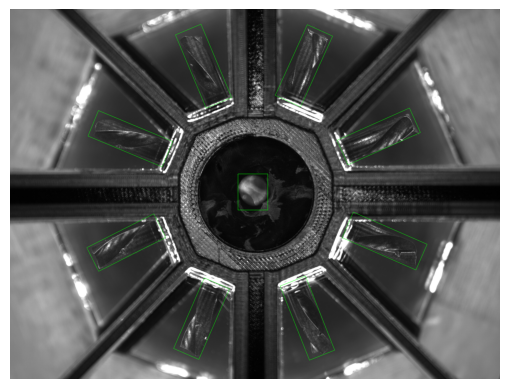

In [ ]:
vis  = img_bgr.copy()

for i in range(len(cls_ids)):
    if cls_ids[i] != 2:
      print(i)
      poly = r_default.masks.xy[i]
      cnt = np.int32(poly).reshape(-1, 1, 2)
      rect = cv2.minAreaRect(cnt)
      box = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))

      # Kiểm tra kiểu dữ liệu của box và đảm bảo đúng cấu trúc
      box = np.array(box, dtype=np.int32).reshape(-1, 1, 2)

      # Vẽ cạnh hình chữ nhật
      cv2.polylines(vis, [box], True, (0, 255, 0), 2)

# Hiển thị (nếu muốn)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
coco_path = "/content/annotations.json"
with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

In [ ]:
pattern = os.path.join("/content/drive/MyDrive/KLTN/ver9_update82_full", '*.bmp')  # ** để tìm trong các thư mục con
jpg_files = glob.glob(pattern, recursive=True)
print(len(jpg_files))

82


In [ ]:
jpg_files[0]

'/content/drive/MyDrive/KLTN/ver9_update82_full/S306_Image__2025-05-29__14-17-30_2_bright_1.bmp'

In [ ]:
# Tạo DataFrame từ tên tệp
df_path = pd.DataFrame(jpg_files, columns=["Filename"] )

# Trích xuất thông tin từ tên tệp
df_path['ID'] = df_path['Filename'].str.extract(r"(S\d+)")  # Lấy ID như S1, S2, S9, ...
df_path['Mode'] = df_path['Filename'].str.extract(r"(bright|dark)")  # Lấy chế độ (bright, dark)
df_path['Index'] = df_path['Filename'].str.extract(r"(\d{1,2}).bmp")  # Lấy số index (1, 2, 3, ...)

df_path['ID_sort'] = df_path['ID'].str.extract(r"(\d+)").astype(int)  # Chuyển ID thành kiểu số để sắp xếp đúng thứ tự
df_path = df_path.sort_values(by='ID_sort')
print(df_path.shape)
# Hiển thị kết quả
df_path.head()

(82, 5)


,Filename,ID,Mode,Index,ID_sort
40,/content/drive/MyDrive/KLTN/ver9_update82_full...,S292,dark,1,292
41,/content/drive/MyDrive/KLTN/ver9_update82_full...,S292,bright,1,292
36,/content/drive/MyDrive/KLTN/ver9_update82_full...,S293,dark,1,293
37,/content/drive/MyDrive/KLTN/ver9_update82_full...,S293,bright,1,293
29,/content/drive/MyDrive/KLTN/ver9_update82_full...,S294,dark,1,294


In [ ]:
# df_path.sort_values(by='ID_sort').to_csv('data.csv', index =False)

In [ ]:
#temp = df_path['Filename'].apply(lambda x : x.split('.')[0][:-4].split('/')[::-1][0])

In [ ]:
#df_path.groupby(['Mode','ID_sort']).count()

In [ ]:
df_bright = df_path[df_path['Mode'] == 'bright']
print(df_bright.shape)
df_bright.head()

(41, 5)


,Filename,ID,Mode,Index,ID_sort
41,/content/drive/MyDrive/KLTN/ver9_update82_full...,S292,bright,1,292
37,/content/drive/MyDrive/KLTN/ver9_update82_full...,S293,bright,1,293
28,/content/drive/MyDrive/KLTN/ver9_update82_full...,S294,bright,1,294
72,/content/drive/MyDrive/KLTN/ver9_update82_full...,S295,bright,1,295
20,/content/drive/MyDrive/KLTN/ver9_update82_full...,S296,bright,1,296


In [ ]:
df_dark= df_path[df_path['Mode'] == 'dark']
print(df_dark.shape)
df_dark.head()

(41, 5)


,Filename,ID,Mode,Index,ID_sort
40,/content/drive/MyDrive/KLTN/ver9_update82_full...,S292,dark,1,292
36,/content/drive/MyDrive/KLTN/ver9_update82_full...,S293,dark,1,293
29,/content/drive/MyDrive/KLTN/ver9_update82_full...,S294,dark,1,294
73,/content/drive/MyDrive/KLTN/ver9_update82_full...,S295,dark,1,295
21,/content/drive/MyDrive/KLTN/ver9_update82_full...,S296,dark,1,296


In [ ]:
def converSegmentToBbox(r, img_path, df_img):
  cls_ids = r.boxes.cls.int().cpu().tolist()
  img_bgr = cv2.imread(img_path)

  vis = img_bgr.copy()
  quads_all, quad_cat_ids = [], []
  for _, row in df_img.iterrows():
      cnt = np.int32(row["segmentation"]).reshape(-1, 1, 2)
      rect = cv2.minAreaRect(cnt)
      box = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))
      quads_all.append(box)
      quad_cat_ids.append(int(row["category_id"]))


  img = img_bgr.copy()  # grayscale hoặc BGR đều được
  H, W = img.shape[:2]

  # --- center: ưu tiên head_drill (class 1), không có thì tâm ảnh ---
  head_idx = next((k for k,c in enumerate(cls_ids) if c==1), None)
  if head_idx is not None:
      hpoly = np.asarray(r.masks.xy[head_idx], np.float32)
      cx, cy = float(hpoly[:,0].mean()), float(hpoly[:,1].mean())
  else:
      cx, cy = W/2.0, H/2.0
  center_xy = (cx, cy)

  #r = res[0]

  # ==== 3) Xử lý từng segment DRILL ====
  results = []  # list các crop: img, bbox_warp_df, meta

  for i, poly in enumerate(r.masks.xy):
      if cls_ids[i] == 0 or cls_ids[i] == 1:
        cnt  = np.int32(poly).reshape(-1,1,2)
        rect = cv2.minAreaRect(cnt)                                # (center,(w,h),angle)
        box4 = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))    # TL,TR,BR,BL


        # 3.3) CẮT + nhận ma trận warp M
        crop_bgra, M_rot, (out_w,out_h), src_quad, dst_quad, mkeep_warp = crop_from_box4_fixed_h(
            img=img_bgr,
            box4=box4,
            center_xy=center_xy,
            out_h_src=OUT_H,
            out_w_norm=OUT_W_NORM,
            pad_lr=pad,
            head_down=False,
            rotate180=True,
            clamp_height=False
        )

        if cls_ids[i] == 1:
            crop_bgra, M_rot, (out_w,out_h), src_quad, dst_quad, mkeep_warp = crop_from_box4_fixed_h(
                img=img_bgr,
                box4=box4,
                center_xy=center_xy,
                out_h_src=OUT_H,
                out_w_norm=OUT_W_NORM,
                pad_lr=pad,
                pad_tb = 50,
                head_down=False,
                rotate180=True,
                clamp_height=True
            )
            # crop_bgra = add_black_background(crop_bgra, new_width=256, new_height=OUT_H)
            # pad lên khung chuẩn 256 x OUT_H (dán tại (0,0))
            new_w = OUT_W_NORM + 2*pad   # 226 + 30 = 256
            new_h = OUT_H                # 720
            if (out_w, out_h) != (new_w, new_h):
                crop_bgra = add_black_background(crop_bgra, new_width=new_w, new_height=new_h)

                # ✅ đồng bộ size để bước tính bbox/clip đúng theo khung mới
                out_w, out_h = new_w, new_h
                if mkeep_warp is not None:
                    if mkeep_warp.ndim == 3:                 # nếu lỡ là 3 kênh
                        mkeep_warp = mkeep_warp[..., 0]
                    mh, mw = mkeep_warp.shape[:2]
                    m0 = np.zeros((out_h, out_w), np.uint8)  # canvas mới

                    copy_h = min(mh, out_h)
                    copy_w = min(mw, out_w)
                    m0[:copy_h, :copy_w] = mkeep_warp[:copy_h, :copy_w]  # dán tại (0,0)

                    mkeep_warp = m0

                # # (tùy) nếu còn dùng mask_limit ở nơi khác, pad mask cho khớp size
                # if mkeep_warp is not None:
                #   Hm, Wm = mkeep_warp.shape[:2]
                #   if Hm > out_h:
                #       mkeep_warp_resized = cv2.resize(mkeep_warp, (Wm, out_h))
                #   else:
                #       mkeep_warp_resized = mkeep_warp

                #   m0 = np.zeros((out_h, out_w), np.uint8)
                #   m0[:mkeep_warp_resized.shape[0], :Wm] = mkeep_warp_resized
                #   mkeep_warp = m0

        idxs = filter_quads_indices_by_segment_in_crop(
            poly_seg=poly,                # polygon segment ở toạ độ gốc
            quads=quads_all,              # quads ở toạ độ gốc
            M_rot=M_rot,                  # homography gốc -> crop (chính cái dùng để warp ảnh)
            out_wh=(out_w, out_h),        # kích thước crop hiện tại
            mode="overlap",               # hoặc "contains"
            thr=0.5,
            dilate_px=3,
        )

        quads_in_seg = [quads_all[j] for j in idxs]
        cats_in_seg  = [quad_cat_ids[j] for j in idxs]

        bboxes_in_crop = bboxes_from_quads_in_crop(
            quads=quads_in_seg,
            M_rot=M_rot,
            out_wh=(out_w, out_h),
            mask_limit=None,
            method="geom",
            clip=True,
            skip_empty=True
        )
        # 3.6) angle score để sắp xếp 12h→… (CW)
        score = angle_score(rect[0], center_xy)
        #print("Số BBox: ",len(bboxes_in_crop))
        #bbox_df = pd.DataFrame(bboxes_in_crop, columns=["x","y","w","h"])
        results.append({
            "seg_idx": i,
            "angle_score": score,
            "crop_bgra": crop_bgra,          # ảnh crop (BGRA)
            "quads_in_seg_global": quads_in_seg,  # quads ở hệ toạ độ gốc
            "bboxes_in_crop": bboxes_in_crop,     # list [x,y,w,h]
            "cls_id": cls_ids[i],
            "category_ids_in_crop": cats_in_seg
        })
  results = sorted(results, key=lambda d: (d["cls_id"] == 1, d["angle_score"]))

  return results

In [ ]:
def converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img):
  cls_ids = r_default.boxes.cls.int().cpu().tolist()
  cls_ids_temp = r.boxes.cls.int().cpu().tolist()
  img_bgr = cv2.imread(img_path)

  vis = img_bgr.copy()
  quads_all, quad_cat_ids = [], []
  for _, row in df_img.iterrows():
      cnt = np.int32(row["segmentation"]).reshape(-1, 1, 2)
      rect = cv2.minAreaRect(cnt)
      box = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))
      quads_all.append(box)
      quad_cat_ids.append(int(row["category_id"]))


  img = img_bgr.copy()  # grayscale hoặc BGR đều được
  H, W = img.shape[:2]

  # --- center: ưu tiên head_drill (class 1), không có thì tâm ảnh ---
  head_idx = next((k for k,c in enumerate(cls_ids_temp) if c==1), None)
  if head_idx is not None:
      hpoly = np.asarray(r.masks.xy[head_idx], np.float32)
      cx, cy = float(hpoly[:,0].mean()), float(hpoly[:,1].mean())
  else:
      cx, cy = W/2.0, H/2.0
  center_xy = (cx, cy)

  #r = res[0]
  check = False
  # ==== 3) Xử lý từng segment DRILL ====
  results = []
  for i, poly in enumerate(r_default.masks.xy):
      if cls_ids[i] == 0 or cls_ids[i] == 1:
        if  cls_ids[i] == 1:

          check = True

          for k in range(len(cls_ids_temp)):
            if cls_ids_temp[k] == 1:
              poly = r.masks.xy[k]



        cnt  = np.int32(poly).reshape(-1,1,2)
        rect = cv2.minAreaRect(cnt)                                # (center,(w,h),angle)
        box4 = order_tl_tr_br_bl(np.int32(cv2.boxPoints(rect)))    # TL,TR,BR,BL


        # 3.3) CẮT + nhận ma trận warp M
        crop_bgra, M_rot, (out_w,out_h), src_quad, dst_quad, mkeep_warp = crop_from_box4_fixed_h(
            img=img_bgr,
            box4=box4,
            center_xy=center_xy,
            out_h_src=650,
            out_w_norm=OUT_W_NORM,
            pad_lr=pad,
            head_down=False,
            rotate180=True,
            clamp_height=False
        )
        crop_bgra = add_black_background(crop_bgra, new_width=256, new_height=720)
        if check:
            crop_bgra, M_rot, (out_w,out_h), src_quad, dst_quad, mkeep_warp = crop_from_box4_fixed_h(
                img=img_bgr,
                box4=box4,
                center_xy=center_xy,
                out_h_src=OUT_H,
                out_w_norm=OUT_W_NORM,
                pad_lr=pad,
                pad_tb = 50,
                head_down=False,
                rotate180=True,
                clamp_height=True
            )
            # crop_bgra = add_black_background(crop_bgra, new_width=256, new_height=OUT_H)
            # pad lên khung chuẩn 256 x OUT_H (dán tại (0,0))
            new_w = OUT_W_NORM + 2*pad   # 226 + 30 = 256
            new_h = OUT_H                # 720
            if (out_w, out_h) != (new_w, new_h):
                crop_bgra = add_black_background(crop_bgra, new_width=new_w, new_height=new_h)

                # ✅ đồng bộ size để bước tính bbox/clip đúng theo khung mới
                out_w, out_h = new_w, new_h
                # Đồng bộ mask (pad/cắt về (out_h, out_w) và dán tại (0,0))
                if mkeep_warp is not None:
                    if mkeep_warp.ndim == 3:                 # nếu lỡ là 3 kênh
                        mkeep_warp = mkeep_warp[..., 0]
                    mh, mw = mkeep_warp.shape[:2]
                    m0 = np.zeros((out_h, out_w), np.uint8)  # canvas mới

                    copy_h = min(mh, out_h)
                    copy_w = min(mw, out_w)
                    m0[:copy_h, :copy_w] = mkeep_warp[:copy_h, :copy_w]  # dán tại (0,0)

                    mkeep_warp = m0

                # # (tùy) nếu còn dùng mask_limit ở nơi khác, pad mask cho khớp size
                # if mkeep_warp is not None:
                #   Hm, Wm = mkeep_warp.shape[:2]
                #   if Hm > out_h:
                #       mkeep_warp_resized = cv2.resize(mkeep_warp, (Wm, out_h))
                #   else:
                #       mkeep_warp_resized = mkeep_warp

                #   m0 = np.zeros((out_h, out_w), np.uint8)
                #   m0[:mkeep_warp_resized.shape[0], :Wm] = mkeep_warp_resized
                #   mkeep_warp = m0

        idxs = filter_quads_indices_by_segment_in_crop(
            poly_seg=poly,                # polygon segment ở toạ độ gốc
            quads=quads_all,              # quads ở toạ độ gốc
            M_rot=M_rot,                  # homography gốc -> crop (chính cái dùng để warp ảnh)
            out_wh=(out_w, out_h),        # kích thước crop hiện tại
            mode="overlap",               # hoặc "contains"
            thr=0.5,
            dilate_px=3,
        )

        quads_in_seg = [quads_all[j] for j in idxs]
        cats_in_seg  = [quad_cat_ids[j] for j in idxs]

        bboxes_in_crop = bboxes_from_quads_in_crop(
            quads=quads_in_seg,
            M_rot=M_rot,
            out_wh=(out_w, out_h),
            mask_limit=None,
            method="geom",
            clip=True,
            skip_empty=True
        )

        # 3.6) angle score để sắp xếp 12h→… (CW)
        score = angle_score(rect[0], center_xy)
        #print("Số BBox: ",len(bboxes_in_crop), "index: ",i)
        #bbox_df = pd.DataFrame(bboxes_in_crop, columns=["x","y","w","h"])
        if check:
          #score = angle_score(rect_t[0], center_xy)
          results.append({
              "seg_idx": i,
              "angle_score": score,
              "crop_bgra": crop_bgra,          # ảnh crop (BGRA)
              "quads_in_seg_global": quads_in_seg,  # quads ở hệ toạ độ gốc
              "bboxes_in_crop": bboxes_in_crop,     # list [x,y,w,h]
              "cls_id": 1,
              "category_ids_in_crop": cats_in_seg
          })
          check = False
        else:
          results.append({
              "seg_idx": i,
              "angle_score": score,
              "crop_bgra": crop_bgra,          # ảnh crop (BGRA)
              "quads_in_seg_global": quads_in_seg,  # quads ở hệ toạ độ gốc
              "bboxes_in_crop": bboxes_in_crop,     # list [x,y,w,h]
              "cls_id": cls_ids[i],
              "category_ids_in_crop": cats_in_seg
          })
  results = sorted(results, key=lambda d: (d["cls_id"] == 1, d["angle_score"]))

  return results

In [ ]:
# ===== Bảng màu (BGR cho OpenCV) =====
CLASS_COLOR = {
    "Gay":     ( 80, 255,  60),   # lime/green
    "Me_Dau":  (200,  70, 255),   # purple
    "Me_Than": (  0, 140, 255),   # orange
    "Mon_Dau": (  0,   0, 255),   # red/pink
    "Ri_set":  (255, 255,   0),   # cyan/teal
    "Xuoc":    (255, 191,   0),   # light blue
}
def color_of(name):  # fallback nếu class lạ
    return CLASS_COLOR.get(str(name), (0, 255, 255))  # default: yellow

In [ ]:
img_path = "/content/drive/MyDrive/KLTN/ver9_update82_full/S293_Image__2025-06-05__11-01-45_1_dark_1.bmp"

df,categories  = load_coco_image_df(coco, image_file=img_path)

In [ ]:
OUT_H    = 720       # chiều cao cố định theo ảnh gốc (px)
OUT_W_NORM = 226
pad = 15

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
categories_df = pd.DataFrame(categories, columns=["id","name","supercategory"])

path_output = "/content/drive/MyDrive/Data_Crop_9_Image/ver9_update82"

In [ ]:
pattern = os.path.join(path_output, '*.jpg')

In [ ]:
next_img_id, next_ann_id = 1, 1
all_images_df_list = []
all_ann_df_list = []
list_image_missing = []
count = 0
pre_check = 0
pos_check = 0
for _,row in df_bright.iterrows():
  img_path = row['Filename']

  res = model.predict(
      source=img_path,
      imgsz=640,
      conf=0.50,
      iou=0.4,
      exist_ok=True,
      verbose=False
  )

  r = res[0]

  #print(row['ID'],row['Index'])
  df_img,_  = load_coco_image_df(coco, image_file=img_path)

  results = converSegmentToBbox(r, img_path, df_img)

  if len(results) != 9:
    results = converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img)
  #print(len(results))

  #image_prefix = img_path.split('.')[0][:-4].split('/')[::-1][0]
  image_prefix = img_path.split('/')[::-1][0].split('.')[0]
  #print(image_prefix)
  images_df, annotations_df, next_img_id, next_ann_id = results_to_coco_dfs(
      results=results,
      image_prefix=image_prefix,
      save_dir=path_output,
      start_img_id=next_img_id, start_ann_id=next_ann_id,
      default_category_id=0,
  )
  all_images_df_list.append(images_df)
  all_ann_df_list.append(annotations_df)
  count =  count + 1
  print(f"STT: {count}. Cắt xong ảnh {row['ID'], row['Index']} với số lượng ảnh {len(results)}")

  if len(images_df) != 9:
    list_image_missing.append(images_df.iloc[0]["file_name"])
  t = df_dark[((df_dark['ID'] == row['ID']) & (df_dark['Index'] == row['Index']))]
  if not t.empty:
    t = t.iloc[0]
    #print(t['ID'],t['Index'])
    img_path = t['Filename']
    df_img,_  = load_coco_image_df(coco, image_file=img_path)
    results = converSegmentToBbox(r, img_path, df_img)

    if len(results) != 9:
      results = converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img)
    #print(len(results))

    #image_prefix = img_path.split('.')[0][:-4].split('/')[::-1][0]
    image_prefix = img_path.split('/')[::-1][0].split('.')[0]
    #print(image_prefix)
    images_df, annotations_df, next_img_id, next_ann_id = results_to_coco_dfs(
        results=results,
        image_prefix=image_prefix,
        save_dir=path_output,
        start_img_id=next_img_id, start_ann_id=next_ann_id,
        default_category_id=0,
    )
    all_images_df_list.append(images_df)
    all_ann_df_list.append(annotations_df)
    count =  count + 1
    print(f"STT: {count}. Cắt xong ảnh {t['ID'],t['Index']} với số lượng ảnh {len(results)}")
  jpg_files = glob.glob(pattern, recursive=True)
  print(f"Tổng file ảnh tính đến hiện tại: {len(jpg_files)}")
  print("====================================================")

STT: 1. Cắt xong ảnh ('S292', '1') với số lượng ảnh 9
STT: 2. Cắt xong ảnh ('S292', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 18
STT: 3. Cắt xong ảnh ('S293', '1') với số lượng ảnh 9
STT: 4. Cắt xong ảnh ('S293', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 36
STT: 5. Cắt xong ảnh ('S294', '1') với số lượng ảnh 9
STT: 6. Cắt xong ảnh ('S294', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 54
STT: 7. Cắt xong ảnh ('S295', '1') với số lượng ảnh 9
STT: 8. Cắt xong ảnh ('S295', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 72
STT: 9. Cắt xong ảnh ('S296', '1') với số lượng ảnh 9
STT: 10. Cắt xong ảnh ('S296', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 90
STT: 11. Cắt xong ảnh ('S297', '1') với số lượng ảnh 9
STT: 12. Cắt xong ảnh ('S297', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 108
STT: 13. Cắt xong ảnh ('S298', '1') với số lượng ảnh 9
STT: 14. Cắt xong ảnh ('S298', '1') với số lượng ảnh 9
Tổng file ảnh tính đến

In [ ]:
list_image_missing

[]

In [ ]:
len(list_image_missing)

0

In [ ]:
from datetime import datetime
# Get the current date and time in the desired format
date_created = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print(date_created)  # Example output: '2025-09-14 15:45:30'

2025-11-11 14:51:35


In [ ]:
info ={
        "year": "2025",
        "version": "train 6",
        "description": "Data Crop 9 Image",
        "contributor": "khanh",
        "url": "https://public.roboflow.com/object-detection/undefined",
        "date_created": date_created
    }
licenses = [
      {
          "id": 1,
          "url": "https://creativecommons.org/licenses/by/4.0/",
          "name": "CC BY 4.0"
      }
  ]

In [ ]:
images_df_all = pd.concat(all_images_df_list, ignore_index=True)
annotations_df_all = pd.concat(all_ann_df_list, ignore_index=True)
# Giờ bạn có 2 DF dùng để kiểm tra/lưu tạm.
# Khi sẵn sàng xuất JSON COCO:
coco_json = {
    "info": info,
    "licenses" : licenses,
    "categories": categories_df.to_dict(orient="records"),
    "images": images_df_all.to_dict(orient="records"),
    "annotations": annotations_df_all.assign(
        bbox=annotations_df_all["bbox"].apply(lambda b: [float(v) for v in b])
    ).to_dict(orient="records")
}
#/content/drive/MyDrive/Data_Crop_9_Image/train/coco_annotations.json
with open("/content/drive/MyDrive/Data_Crop_9_Image/ver5_update/train/_annotations_coco.json", "w", encoding="utf-8") as f:
    json.dump(coco_json, f, ensure_ascii=False)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


#test

In [ ]:
path_output = "/content/drive/MyDrive/Data_Crop_9_Image/ver7_update134"
coco_path = "/content/Drill_Detection-18/test/_annotations.coco.json"
with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

img_path = "/content/Drill_Detection-18/test/S237_Image__2025-11-11__10-19-17_bright_1_bmp.rf.5d21951e25bda99a946946ec0f9d1af6.jpg"

df,categories  = load_coco_image_df(coco, image_file=img_path)

pattern = os.path.join("/content/Drill_Detection-18/test", '*.jpg')  # ** để tìm trong các thư mục con
jpg_files = glob.glob(pattern, recursive=True)

# Tạo DataFrame từ tên tệp
df_path = pd.DataFrame(jpg_files, columns=["Filename"])

# Trích xuất thông tin từ tên tệp
df_path['ID'] = df_path['Filename'].str.extract(r"(S\d+)")  # Lấy ID như S1, S2, S9, ...
df_path['Mode'] = df_path['Filename'].str.extract(r"(bright|dark)")  # Lấy chế độ (bright, dark)
df_path['Index'] = df_path['Filename'].str.extract(r"(\d{1,2})_bmp")  # Lấy số index (1, 2, 3, ...)

df_path['ID_sort'] = df_path['ID'].str.extract(r"(\d+)").astype(int)  # Chuyển ID thành kiểu số để sắp xếp đúng thứ tự
df_path = df_path.sort_values(by='ID_sort')
print(df_path.shape)
# Hiển thị kết quả
df_path.head()

df_bright = df_path[df_path['Mode'] == 'bright']
print(df_bright.shape)
df_bright.head()

df_dark= df_path[df_path['Mode'] == 'dark']
print(df_dark.shape)
df_dark.head()

(134, 5)
(67, 5)
(67, 5)


,Filename,ID,Mode,Index,ID_sort
49,/content/Drill_Detection-18/test/S237_Image__2...,S237,dark,2,237
132,/content/Drill_Detection-18/test/S237_Image__2...,S237,dark,1,237
31,/content/Drill_Detection-18/test/S238_Image__2...,S238,dark,2,238
22,/content/Drill_Detection-18/test/S238_Image__2...,S238,dark,4,238
46,/content/Drill_Detection-18/test/S238_Image__2...,S238,dark,7,238


In [ ]:
pattern = os.path.join("/content/drive/MyDrive/Data_Crop_9_Image/ver7_update134", '*.jpg')

In [ ]:
next_img_id, next_ann_id = 1, 1
all_images_df_list = []
all_ann_df_list = []
list_image_missing = []
count = 0
for _,row in df_bright.iterrows():
  img_path = row['Filename']

  res = model.predict(
      source=img_path,
      imgsz=640,
      conf=0.50,
      iou=0.5,
      exist_ok=True,
      verbose=False
  )

  r = res[0]

  #print(row['ID'],row['Index'])
  df_img,_  = load_coco_image_df(coco, image_file=img_path)

  results = converSegmentToBbox(r, img_path, df_img)

  if len(results) != 9:
    results = converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img)

  image_prefix = img_path.split('.')[0][:-4].split('/')[::-1][0]
  #print(image_prefix)
  images_df, annotations_df, next_img_id, next_ann_id = results_to_coco_dfs(
      results=results,
      image_prefix=image_prefix,
      save_dir=path_output,
      start_img_id=next_img_id, start_ann_id=next_ann_id,
      default_category_id=0,
  )
  all_images_df_list.append(images_df)
  all_ann_df_list.append(annotations_df)
  count =  count + 1
  print(f"STT: {count}. Cắt xong ảnh {row['ID'], row['Index']} với số lượng ảnh {len(results)}")

  if len(images_df) != 9:
    list_image_missing.append(images_df.iloc[0]["file_name"])
  t = df_dark[((df_dark['ID'] == row['ID']) & (df_dark['Index'] == row['Index']))]
  if not t.empty:
    t = t.iloc[0]
    #print(t['ID'],t['Index'])
    img_path = t['Filename']
    df_img,_  = load_coco_image_df(coco, image_file=img_path)
    results = converSegmentToBbox(r, img_path, df_img)

    if len(results) != 9:
      results = converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img)


    image_prefix = img_path.split('.')[0][:-4].split('/')[::-1][0]
    #print(image_prefix)
    images_df, annotations_df, next_img_id, next_ann_id = results_to_coco_dfs(
        results=results,
        image_prefix=image_prefix,
        save_dir=path_output,
        start_img_id=next_img_id, start_ann_id=next_ann_id,
        default_category_id=0,
    )
    all_images_df_list.append(images_df)
    all_ann_df_list.append(annotations_df)
    count = count + 1
    print(f"STT: {count}. Cắt xong ảnh {t['ID'],t['Index']} với số lượng ảnh {len(results)}")

  jpg_files = glob.glob(pattern, recursive=True)
  print(f"Tổng file ảnh tính đến hiện tại: {len(jpg_files)}")

  print("================================================")

STT: 1. Cắt xong ảnh ('S237', '2') với số lượng ảnh 9
STT: 2. Cắt xong ảnh ('S237', '2') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 18
STT: 3. Cắt xong ảnh ('S237', '1') với số lượng ảnh 9
STT: 4. Cắt xong ảnh ('S237', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 36
STT: 5. Cắt xong ảnh ('S238', '3') với số lượng ảnh 9
STT: 6. Cắt xong ảnh ('S238', '3') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 54
STT: 7. Cắt xong ảnh ('S238', '7') với số lượng ảnh 9
STT: 8. Cắt xong ảnh ('S238', '7') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 72
STT: 9. Cắt xong ảnh ('S238', '2') với số lượng ảnh 9
STT: 10. Cắt xong ảnh ('S238', '2') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 90
STT: 11. Cắt xong ảnh ('S238', '5') với số lượng ảnh 9
STT: 12. Cắt xong ảnh ('S238', '5') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 108
STT: 13. Cắt xong ảnh ('S238', '6') với số lượng ảnh 9
STT: 14. Cắt xong ảnh ('S238', '6') với số lượng ảnh 9
Tổng file ảnh tính đến

In [ ]:
list_image_missing

[]

In [ ]:
categories_df

,id,name,supercategory
0,0,drill,none
1,1,Gay,drill
2,2,Me,drill
3,3,Mon_dau,drill
4,4,Ri_set,drill
5,5,Xuoc,drill


In [ ]:
info ={
        "year": "2025",
        "version": "update ver6",
        "description": "Data Crop 9 Image",
        "contributor": "khanh",
        "url": "https://public.roboflow.com/object-detection/undefined",
        "date_created": date_created
    }
licenses = [
      {
          "id": 1,
          "url": "https://creativecommons.org/licenses/by/4.0/",
          "name": "CC BY 4.0"
      }
  ]


images_df_all = pd.concat(all_images_df_list, ignore_index=True)
annotations_df_all = pd.concat(all_ann_df_list, ignore_index=True)
# Giờ bạn có 2 DF dùng để kiểm tra/lưu tạm.
# Khi sẵn sàng xuất JSON COCO:
coco_json = {
    "info": info,
    "licenses" : licenses,
    "categories": categories_df.to_dict(orient="records"),
    "images": images_df_all.to_dict(orient="records"),
    "annotations": annotations_df_all.assign(
        bbox=annotations_df_all["bbox"].apply(lambda b: [float(v) for v in b])
    ).to_dict(orient="records")
}
#/content/drive/MyDrive/Data_Crop_9_Image/train/coco_annotations.json
with open("/content/drive/MyDrive/Data_Crop_9_Image/ver7_update134/_annotations_coco.json", "w", encoding="utf-8") as f:
    json.dump(coco_json, f, ensure_ascii=False)

#valid

In [ ]:
path_output = "/content/drive/MyDrive/Data_Crop_9_Image/ver5_update/valid"
coco_path = "/content/update_image_drill-1/valid/_annotations.coco.json"
with open(coco_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

# img_path = "/content/Drill_Detection-1/train/S9_than_Image__2025-09-03__14-46-16_bright_2_bmp.rf.bfd007d2e8c6945e22774c658a5e4c92.jpg"

# df,categories  = load_coco_image_df(coco, image_file=img_path)

pattern = os.path.join("/content/update_image_drill-1/valid", '*.jpg')  # ** để tìm trong các thư mục con
jpg_files = glob.glob(pattern, recursive=True)

# Tạo DataFrame từ tên tệp
df_path = pd.DataFrame(jpg_files, columns=["Filename"])

# Trích xuất thông tin từ tên tệp
df_path['ID'] = df_path['Filename'].str.extract(r"(S\d+)")  # Lấy ID như S1, S2, S9, ...
df_path['Mode'] = df_path['Filename'].str.extract(r"(bright|dark)")  # Lấy chế độ (bright, dark)
df_path['Index'] = df_path['Filename'].str.extract(r"(\d{1,2})_bmp")  # Lấy số index (1, 2, 3, ...)

df_path['ID_sort'] = df_path['ID'].str.extract(r"(\d+)").astype(int)  # Chuyển ID thành kiểu số để sắp xếp đúng thứ tự
df_path = df_path.sort_values(by='ID_sort')
print(df_path.shape)
# Hiển thị kết quả
df_path.head()

df_bright = df_path[df_path['Mode'] == 'bright']
print(df_bright.shape)
df_bright.head()

df_dark= df_path[df_path['Mode'] == 'dark']
print(df_dark.shape)
df_dark.head()

(12, 5)
(6, 5)
(6, 5)


,Filename,ID,Mode,Index,ID_sort
11,/content/update_image_drill-1/valid/S190_Image...,S190,dark,1,190
3,/content/update_image_drill-1/valid/S209_Image...,S209,dark,1,209
4,/content/update_image_drill-1/valid/S218_Image...,S218,dark,1,218
5,/content/update_image_drill-1/valid/S218_Image...,S218,dark,4,218
0,/content/update_image_drill-1/valid/S218_Image...,S218,dark,2,218


In [ ]:
pattern = os.path.join("/content/drive/MyDrive/Data_Crop_9_Image/ver5_update/valid", '*.jpg')

In [ ]:
next_img_id, next_ann_id = 1, 1
all_images_df_list = []
all_ann_df_list = []
list_image_missing = []
count = 0
for _,row in df_bright.iterrows():
  img_path = row['Filename']

  res = model.predict(
      source=img_path,
      imgsz=640,
      conf=0.50,
      iou=0.5,
      exist_ok=True,
      verbose=False
  )

  r = res[0]

  #print(row['ID'],row['Index'])
  df_img,_  = load_coco_image_df(coco, image_file=img_path)

  results = converSegmentToBbox(r, img_path, df_img)

  if len(results) != 9:
    results = converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img)
  #print(len(results))

  image_prefix = img_path.split('.')[0][:-4].split('/')[::-1][0]
  #print(image_prefix)
  images_df, annotations_df, next_img_id, next_ann_id = results_to_coco_dfs(
      results=results,
      image_prefix=image_prefix,
      save_dir=path_output,
      start_img_id=next_img_id, start_ann_id=next_ann_id,
      default_category_id=0,
  )
  all_images_df_list.append(images_df)
  all_ann_df_list.append(annotations_df)

  count =  count + 1
  print(f"STT: {count}. Cắt xong ảnh {row['ID'], row['Index']} với số lượng ảnh {len(results)}")

  if len(images_df) != 9:
    list_image_missing.append(images_df.iloc[0]["file_name"])
  t = df_dark[((df_dark['ID'] == row['ID']) & (df_dark['Index'] == row['Index']))]
  if not t.empty:
    t = t.iloc[0]
    #print(t['ID'],t['Index'])
    img_path = t['Filename']
    df_img,_  = load_coco_image_df(coco, image_file=img_path)
    results = converSegmentToBbox(r, img_path, df_img)

    if len(results) != 9:
      results = converSegmentToBbox_Head_Drill(r_default, r, img_path, df_img)
    #print(len(results))

    image_prefix = img_path.split('.')[0][:-4].split('/')[::-1][0]
    #print(image_prefix)
    images_df, annotations_df, next_img_id, next_ann_id = results_to_coco_dfs(
        results=results,
        image_prefix=image_prefix,
        save_dir=path_output,
        start_img_id=next_img_id, start_ann_id=next_ann_id,
        default_category_id=0,
    )
    all_images_df_list.append(images_df)
    all_ann_df_list.append(annotations_df)
    count = count + 1
    print(f"STT: {count}. Cắt xong ảnh {t['ID'],t['Index']} với số lượng ảnh {len(results)}")

  jpg_files = glob.glob(pattern, recursive=True)
  print(f"Tổng file ảnh tính đến hiện tại: {len(jpg_files)}")

  print("============================================")

STT: 1. Cắt xong ảnh ('S190', '1') với số lượng ảnh 9
STT: 2. Cắt xong ảnh ('S190', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 18
STT: 3. Cắt xong ảnh ('S209', '1') với số lượng ảnh 9
STT: 4. Cắt xong ảnh ('S209', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 36
STT: 5. Cắt xong ảnh ('S218', '1') với số lượng ảnh 9
STT: 6. Cắt xong ảnh ('S218', '1') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 54
STT: 7. Cắt xong ảnh ('S218', '2') với số lượng ảnh 9
STT: 8. Cắt xong ảnh ('S218', '2') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 72
STT: 9. Cắt xong ảnh ('S218', '4') với số lượng ảnh 9
STT: 10. Cắt xong ảnh ('S218', '4') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 90
STT: 11. Cắt xong ảnh ('S218', '3') với số lượng ảnh 9
STT: 12. Cắt xong ảnh ('S218', '3') với số lượng ảnh 9
Tổng file ảnh tính đến hiện tại: 108


In [ ]:
list_image_missing

[]

In [ ]:
info ={
        "year": "2025",
        "version": "valid 5",
        "description": "Data Crop 9 Image",
        "contributor": "khanh",
        "url": "https://public.roboflow.com/object-detection/undefined",
        "date_created": date_created
    }
licenses = [
      {
          "id": 1,
          "url": "https://creativecommons.org/licenses/by/4.0/",
          "name": "CC BY 4.0"
      }
  ]


images_df_all = pd.concat(all_images_df_list, ignore_index=True)
annotations_df_all = pd.concat(all_ann_df_list, ignore_index=True)
# Giờ bạn có 2 DF dùng để kiểm tra/lưu tạm.
# Khi sẵn sàng xuất JSON COCO:
coco_json = {
    "info": info,
    "licenses" : licenses,
    "categories": categories_df.to_dict(orient="records"),
    "images": images_df_all.to_dict(orient="records"),
    "annotations": annotations_df_all.assign(
        bbox=annotations_df_all["bbox"].apply(lambda b: [float(v) for v in b])
    ).to_dict(orient="records")
}
#/content/drive/MyDrive/Data_Crop_9_Image/train/coco_annotations.json
with open("/content/drive/MyDrive/Data_Crop_9_Image/ver5_update/valid/_annotations_coco.json", "w", encoding="utf-8") as f:
    json.dump(coco_json, f, ensure_ascii=False)